*This notebook was created by [Sergey Tomin](http://www.xfel.eu/organization/staff/tomin_sergey/) for Workshop: [Designing future X-ray FELs](http://www.xrayfels.co.uk/). Source and license info is on [GitHub](https://github.com/iagapov/ocelot/tree/dev/docs). August 2016.*

## Tutorial N3. Space Charge.
*Second order tracking with space charge effect of the 200k particles.*

As an example, we will use lattice file (converted to Ocelot format) of the European XFEL Injector. 

The space charge forces are calculated by solving the Poisson equation in the bunch frame. 
Then the Lorentz transformed electromagnetic field is applied as a kick in the laboratory frame.
For the solution of the Poisson equation we use an integral representation of the electrostatic potential by convolution of the free-space Green's function with the charge distribution. The convolution equation is solved with the help of the Fast Fourier Transform (FFT). The same algorithm for solution of the 3D Poisson equation is used, for example, in [ASTRA](http://www.desy.de/~mpyflo/).

#### This example will cover the following topics:
* Initialization of the Space Charge objects and the places of their applying
* tracking of second order with space charge effect.

#### Requirements 
* injector_lattice.py - input file, the The European XFEL Injector lattice.
* beam_6MeV.ast    - input file, initial beam distribution in ASTRA format (was obtained from s2e simulation performed with ASTRA).

## Import of modules

In [1]:
# the output of plotting commands is displayed inline within frontends, 
# directly below the code cell that produced it
%matplotlib inline

from time import time 

# this python library provides generic shallow (copy) and deep copy (deepcopy) operations 
from copy import deepcopy

# import from Ocelot main modules and functions
from ocelot import *

# import from Ocelot graphical modules
from ocelot.gui.accelerator import *

# import injector lattice
from ocelot.test.workshop.injector_lattice import *

# load beam distribution
# this function convert Astra beam distribution to Ocelot format - ParticleArray. ParticleArray is designed for tracking.
# in order to work with converters we have to import specific module from ocelot.adaptors
from ocelot.adaptors.astra2ocelot import *

initializing ocelot...


### Change RF parameters for the comparison with ASTRA

In [2]:
phi1=18.7268
V1=18.50662e-3/np.cos(phi1*pi/180)

C_A1_1_1_I1.v = V1; C_A1_1_1_I1.phi = phi1
C_A1_1_2_I1.v = V1; C_A1_1_2_I1.phi = phi1
C_A1_1_3_I1.v = V1; C_A1_1_3_I1.phi = phi1
C_A1_1_4_I1.v = V1; C_A1_1_4_I1.phi = phi1
C_A1_1_5_I1.v = V1; C_A1_1_5_I1.phi = phi1
C_A1_1_6_I1.v = V1; C_A1_1_6_I1.phi = phi1
C_A1_1_7_I1.v = V1; C_A1_1_7_I1.phi = phi1
C_A1_1_8_I1.v = V1; C_A1_1_8_I1.phi = phi1

phi13=180
V13=-20.2E-3/8/np.cos(phi13*pi/180)

C3_AH1_1_1_I1.v=V13; C3_AH1_1_1_I1.phi=phi13
C3_AH1_1_2_I1.v=V13; C3_AH1_1_2_I1.phi=phi13
C3_AH1_1_3_I1.v=V13; C3_AH1_1_3_I1.phi=phi13
C3_AH1_1_4_I1.v=V13; C3_AH1_1_4_I1.phi=phi13
C3_AH1_1_5_I1.v=V13; C3_AH1_1_5_I1.phi=phi13
C3_AH1_1_6_I1.v=V13; C3_AH1_1_6_I1.phi=phi13
C3_AH1_1_7_I1.v=V13; C3_AH1_1_7_I1.phi=phi13
C3_AH1_1_8_I1.v=V13; C3_AH1_1_8_I1.phi=phi13

Imax =  13.2271826253


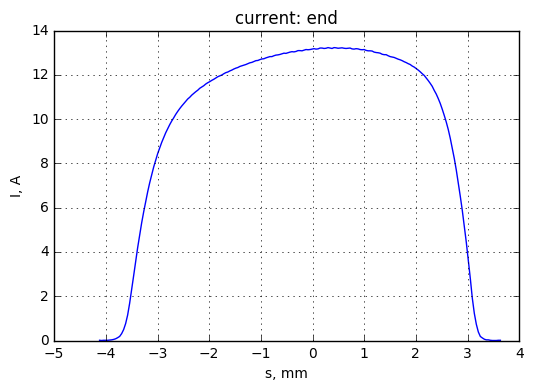

In [3]:
# load and convert ASTRA file to OCELOT beam distribution
# p_array_init = astraBeam2particleArray(filename='beam_6MeV.ast')

# save ParticleArray to compresssed numpy array 
# save_particle_array("sc_beam.npz", p_array_init)
p_array_init = load_particle_array("sc_beam.npz")
bins_start, hist_start = get_current(p_array_init, charge=p_array_init.q_array[0], num_bins=200)

plt.title("current: end")
plt.plot(bins_start*1000, hist_start)
plt.xlabel("s, mm")
plt.ylabel("I, A")
plt.grid(True)
plt.show()

In [4]:
# initialization of tracking method
method = MethodTM()

# for second order tracking we have to choose SecondTM 
method.global_method = SecondTM

# for first order tracking uncomment next line
# method.global_method = TransferMap

# we will start simulation from point 3.2 from the gun. 
# For this purpose  marker was created (start_sim=Marker()) 
# and placed in 3.2 m after gun 
# Q_38_I1 is quadrupole between RF cavities 1.3 GHz and 3.9 GHz
# C3_AH1_1_8_I1 is the last section of the 3.9 GHz cavity
lat = MagneticLattice(cell, start=start_sim, stop=Q_38_I1, method=method)

## Initializing SpaceCharge

In [5]:
sc1 = SpaceCharge()
sc1.nmesh_xyz = [63, 63, 63]
sc1.step = 1

sc5 = SpaceCharge()
sc5.nmesh_xyz = [63, 63, 63]
sc5.step = 5

In [6]:
navi = Navigator(lat)

# add physics processes from the first element to the last of the lattice
navi.add_physics_proc(sc1, lat.sequence[0], C_A1_1_2_I1)
navi.add_physics_proc(sc5, C_A1_1_2_I1, lat.sequence[-1])

# definiing of unit step in [m]
navi.unit_step = 0.02

# deep copy of the initial beam distribution 
p_array = deepcopy(p_array_init)
start = time()
tws_track, p_array = track(lat, p_array, navi)

print("time exec: ", time() - start, "sec")

z = 12.6974 / 12.697400000000007 : applied: time exec:  135.0920000076294 sec


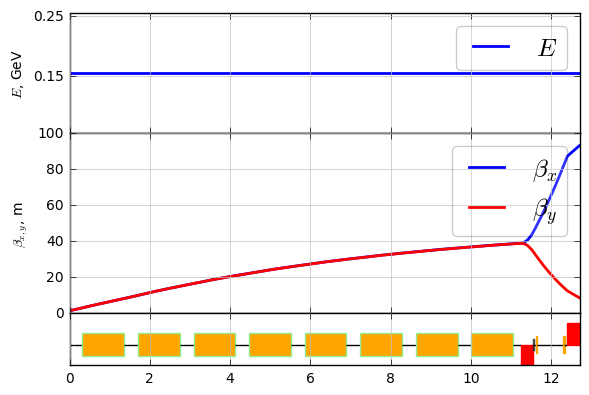

In [7]:
# you can change top_plot argument, for example top_plot=["alpha_x", "alpha_y"]
plot_opt_func(lat, tws_track, top_plot=["E"], fig_name=0, legend=False)
plt.show()

# Comparison with ASTRA
Beam tracking with ASTRA was performed by Igor Zagorodnov (DESY). 

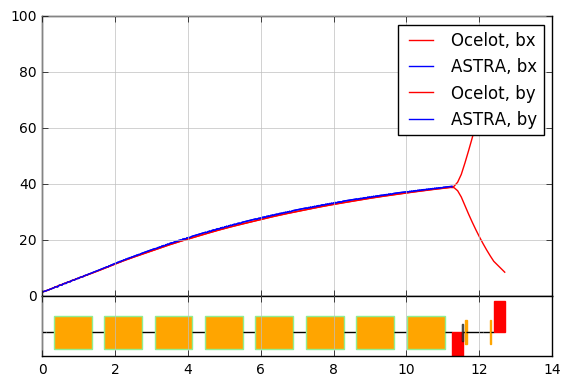

In [8]:
sa, bx_sc, by_sc, bx_wo_sc, by_wo_sc = np.loadtxt("astra_sim.txt", usecols=(0, 1, 2, 3, 4), unpack=True)

s = [tw.s for tw in tws_track]
bx = [tw.beta_x for tw in tws_track]
by = [tw.beta_y for tw in tws_track]
fig, ax = plot_API(lat, legend=False)
ax.plot(s, bx, "r", label="Ocelot, bx")
ax.plot(sa-3.2, bx_sc, "b-",label="ASTRA, bx")
ax.plot(s, by, "r", label="Ocelot, by")
ax.plot(sa-3.2, by_sc, "b-",label="ASTRA, by")
ax.legend()
plt.show()